In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string

try:
    stopwords.words('english')
except LookupError:
    print("Downloading stopwords...")
    nltk.download('stopwords')

chunk_size = 100000
filtered_chunks = []
target_categories = [
    'Credit reporting, credit repair services, or other personal consumer reports',
    'Debt collection',
    'Consumer Loan',
    'Mortgage'
]

print("Loading dataset in chunks...")
with pd.read_csv('https://files.consumerfinance.gov/ccdb/complaints.csv.zip', chunksize=chunk_size) as reader:
    for i, chunk in enumerate(reader):
        print(f"Processing chunk {i+1}...")
        df_filtered = chunk.dropna(subset=['Consumer complaint narrative']).copy()
        df_filtered = df_filtered[['Product', 'Consumer complaint narrative']]
        final_chunk = df_filtered[df_filtered['Product'].isin(target_categories)]
        filtered_chunks.append(final_chunk)

print("\nCombining filtered chunks...")
df_final = pd.concat(filtered_chunks, ignore_index=True)
print("Data loading and filtering complete.")

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

print("Preprocessing text data...")
df_final['cleaned_narrative'] = df_final['Consumer complaint narrative'].apply(preprocess_text)
print("Preprocessing complete.")

print("\nFinal DataFrame shape:", df_final.shape)
df_final.head()

Loading dataset in chunks...
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Processing chunk 36...
Processing chunk 37...
Processing chunk 38...
Processing chunk 39...
Processing chunk 40...
Processing chunk 41...
Processing chunk 42...
Processing chu

,Product,Consumer complaint narrative,cleaned_narrative
0,"Credit reporting, credit repair services, or o...",These are not my accounts.,accounts
1,"Credit reporting, credit repair services, or o...","I wrote three requests, the unverified account...",wrote three requests unverified accounts liste...
2,"Credit reporting, credit repair services, or o...",I paid off my Synchrony Lowes account. After t...,paid synchrony lowes account account paid sync...
3,"Credit reporting, credit repair services, or o...",I've found that my credit report has erroneous...,ive found credit report erroneous information ...
4,Debt collection,RE : Attentively review my formal writ compose...,attentively review formal writ composed declar...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df_final['cleaned_narrative']
y = df_final['Product']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y 
)

print("Data splitting complete.")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

tfidf_vectorizer = TfidfVectorizer(max_features=5000) 

print("\nFitting TF-IDF Vectorizer on the training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

print("Transforming the test data...")
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Feature engineering complete.")
print("Shape of TF-IDF training data:", X_train_tfidf.shape)
print("Shape of TF-IDF test data:", X_test_tfidf.shape)

Data splitting complete.
Training set shape: (1058562,)
Testing set shape: (264641,)

Fitting TF-IDF Vectorizer on the training data...
Transforming the test data...
Feature engineering complete.
Shape of TF-IDF training data: (1058562, 5000)
Shape of TF-IDF test data: (264641, 5000)


--- Training Multinomial Naive Bayes ---
--- Evaluating Multinomial Naive Bayes ---

Classification Report:

                                                                              precision    recall  f1-score   support

                                                               Consumer Loan       0.43      0.26      0.33      1892
Credit reporting, credit repair services, or other personal consumer reports       0.90      0.92      0.91    161456
                                                             Debt collection       0.85      0.77      0.80     74326
                                                                    Mortgage       0.80      0.95      0.87     26967

                                                                    accuracy                           0.87    264641
                                                                   macro avg       0.75      0.72      0.73    264641
                                                               

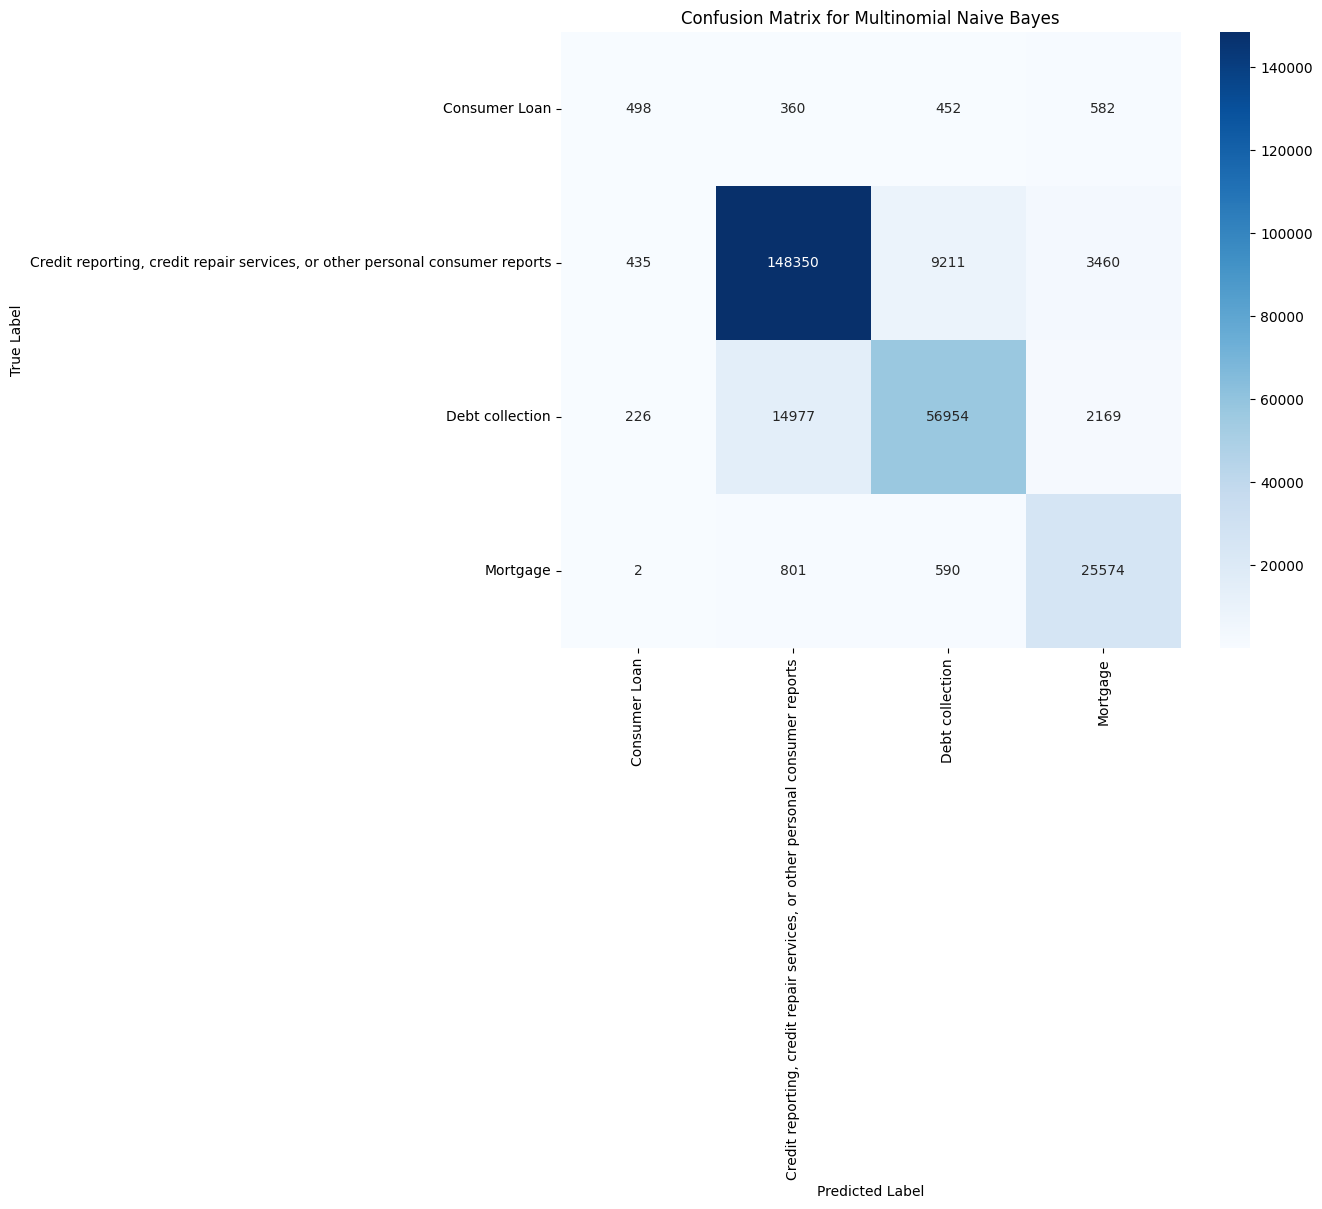

--------------------------------------------------

--- Training Logistic Regression ---
--- Evaluating Logistic Regression ---

Classification Report:

                                                                              precision    recall  f1-score   support

                                                               Consumer Loan       0.68      0.36      0.47      1892
Credit reporting, credit repair services, or other personal consumer reports       0.92      0.94      0.93    161456
                                                             Debt collection       0.87      0.83      0.85     74326
                                                                    Mortgage       0.92      0.93      0.92     26967

                                                                    accuracy                           0.91    264641
                                                                   macro avg       0.85      0.77      0.79    264641
                   

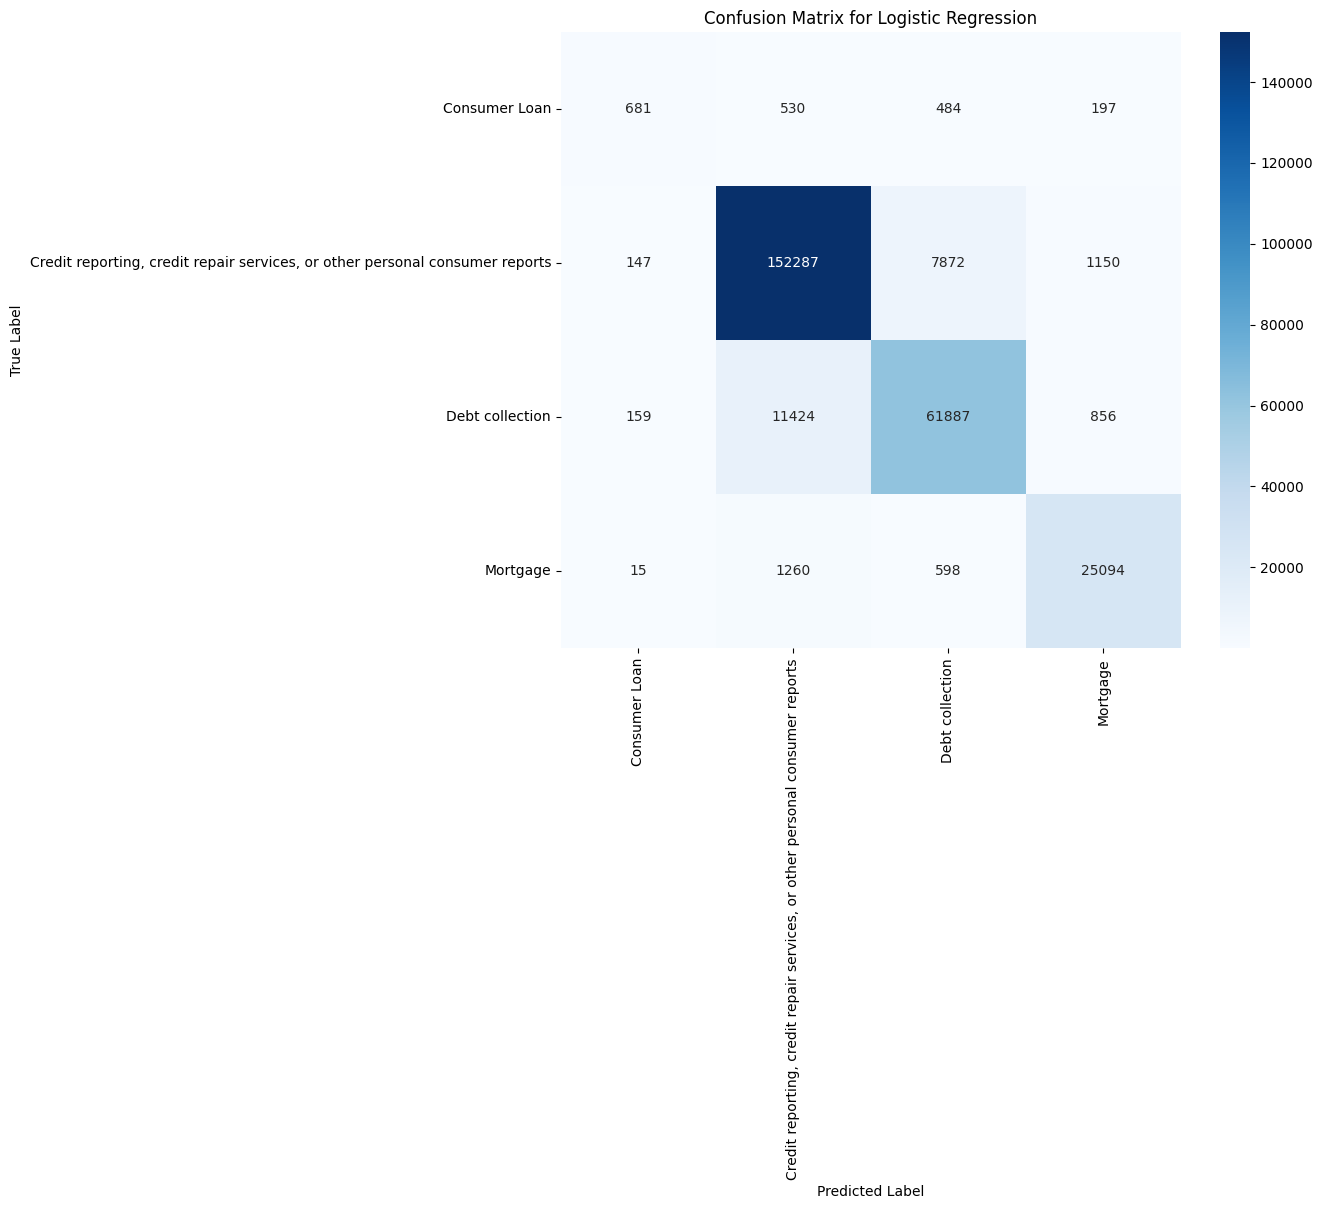

--------------------------------------------------

--- Training Linear SVM ---
--- Evaluating Linear SVM ---

Classification Report:

                                                                              precision    recall  f1-score   support

                                                               Consumer Loan       0.78      0.29      0.43      1892
Credit reporting, credit repair services, or other personal consumer reports       0.92      0.95      0.93    161456
                                                             Debt collection       0.88      0.83      0.85     74326
                                                                    Mortgage       0.91      0.93      0.92     26967

                                                                    accuracy                           0.91    264641
                                                                   macro avg       0.87      0.75      0.78    264641
                                     

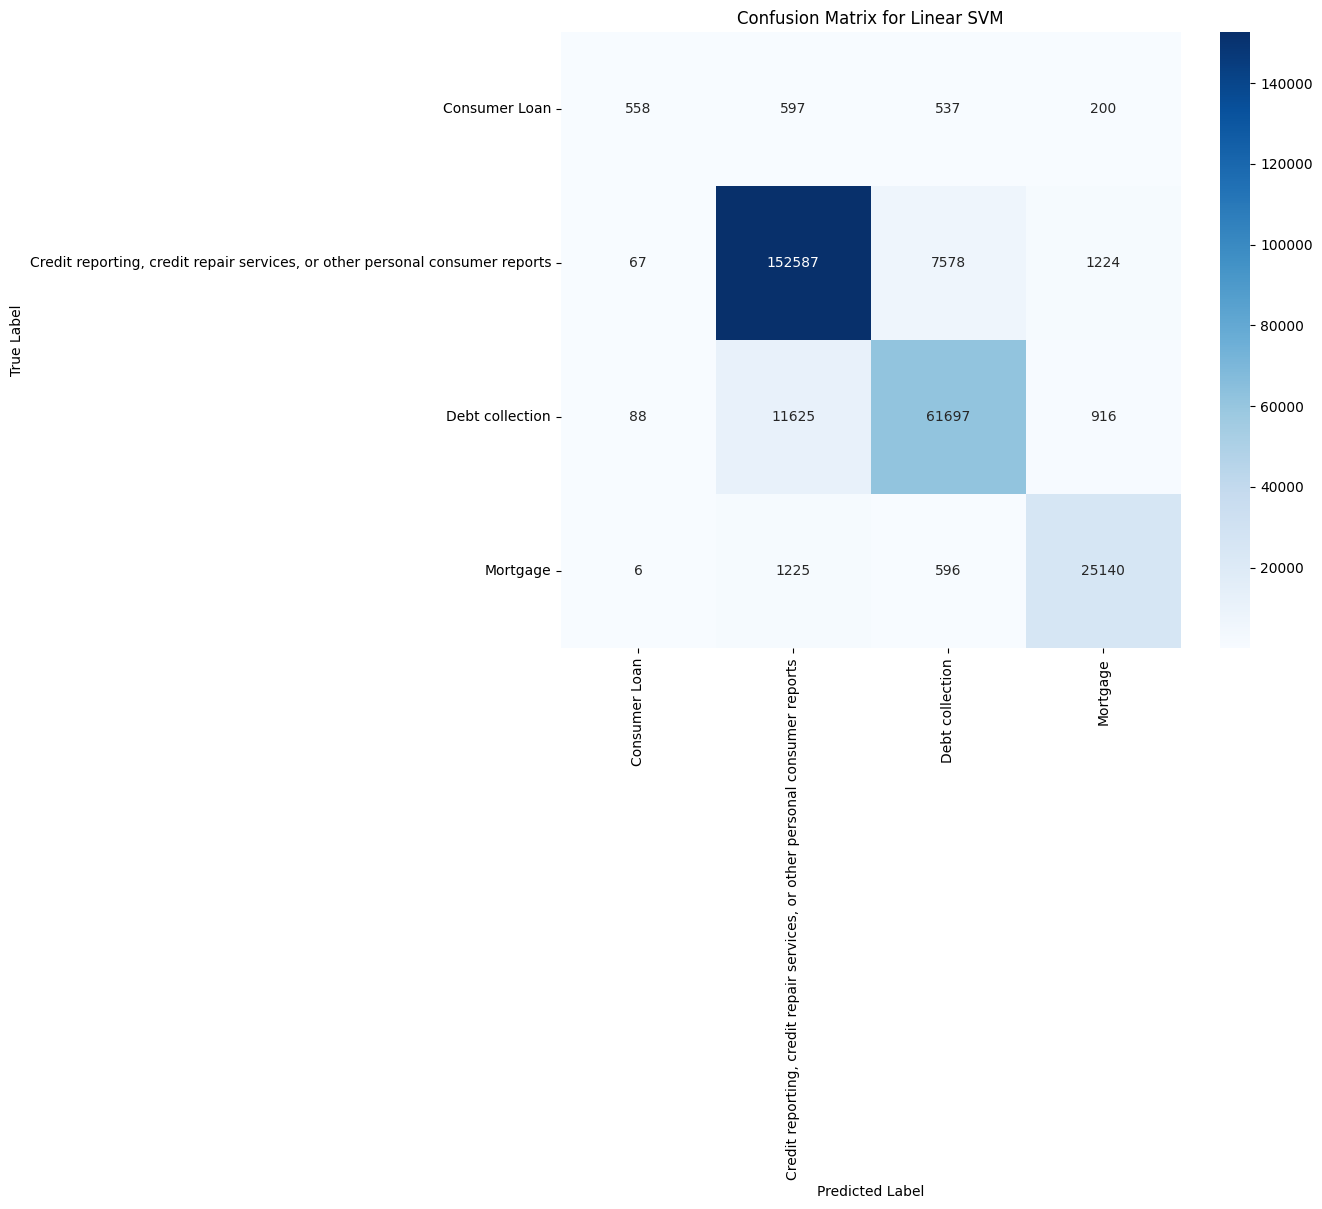

--------------------------------------------------


--- Overall Model Performance Comparison ---
                     Model  Accuracy  Precision (macro)  Recall (macro)  F1-Score (macro)
0  Multinomial Naive Bayes  0.874301           0.745716        0.724164          0.727977
1      Logistic Regression  0.906696           0.848174        0.766584          0.794922
2               Linear SVM  0.906821           0.871553        0.750583          0.783826


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC()
}

performance_data = []

for model_name, model in models.items():
    print(f"--- Training {model_name} ---")
    model.fit(X_train_tfidf, y_train)
    
    print(f"--- Evaluating {model_name} ---")
    y_pred = model.predict(X_test_tfidf)
    
    print("\nClassification Report:\n")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    
    performance_data.append({
        "Model": model_name,
        "Accuracy": report['accuracy'],
        "Precision (macro)": report['macro avg']['precision'],
        "Recall (macro)": report['macro avg']['recall'],
        "F1-Score (macro)": report['macro avg']['f1-score']
    })
    
    print("\nConfusion Matrix:\n")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    print("-" * 50 + "\n")

print("\n--- Overall Model Performance Comparison ---")
performance_df = pd.DataFrame(performance_data)
print(performance_df.to_string())